# AVO class 4 reference values

A little investigation on the reliability of the values given in _"Principles of AVO crossplotting"_ (Castagna et al., 1997, The Leading Edge) and _"Framework for AVO Gradient and Intercept Interpretation"_ (Castagna et al., 1998, Geophysics).

**TO-DO:** 

- Use Batzle-Wang to check fluid moduli
- use rock physics models to get reference values for all AVO classes

***

The next cell block does the standard imports plus a few other functions I have defined in a separate file to make this notebook more readable. The additional functions are:

* `gassmann` to implement Gassmann's equation
* `bulk` to get bulk modulus from Vp, Vs and density
* `shuey` to calculate the reflectivity variation with angle
* `gassmann_phi` to get porosity from Gassmann's equation
* `classref` to plot AVO classes

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from avo_class_4_investigation_funcs import *
import ipywidgets as ipw

The table below shows the elastic properties for the various AVO classes taken from "[Seismic Amplitude Interpretation]((http://library.seg.org/doi/book/10.1190/1.9781560801993)" (Hilterman, 2001, Distinguished Instructor Short Course, SEG, section 4.13) and "Principles of AVO crossplotting" (Castagna et al., 1997, The Leading Edge):

facies        | AVO |  Vp   | Vs    | density | porosity
--------------|-----|-------|-------|---------|----------
shale         | 1   | 3094  | 1515  | 2.40    |
gas sand      | 1   | 4050  | 2526  | 2.21    | 0.20
brine sand    | 1   | 4115  | 2543  | 2.32    | 0.20
shale         | 2   | 2643  | 1167  | 2.29    |
gas sand      | 2   | 2781  | 1665  | 2.08    | 0.25
brine sand    | 2   | 3048  | 1595  | 2.23    | 0.25
shale         | 3   | 2192  | 818   | 2.16    |
gas sand      | 3   | 1543  | 901   | 1.88    | 0.33
brine sand    | 3   | 2134  | 860   | 2.11    | 0.33
shale         | 4   | 3240  | 1620  | 2.34    |
gas sand      | 4   | 1650  | 1090  | 2.07    | ?
brine sand    | 4   | 2590  | 1060  | 2.21    | ?

Porosity is unknown for class 4.

First we build 3 tables detailing the elastic properties $V_p$, $V_s$ and $\rho$ plus porosity for shales, gas sands and brine sands for each AVO class:

In [2]:
tmp_shale = np.array([[3094,1515,2.40,0], [2643,1167,2.29,0], [2192,818,2.16,0], [3240,1620,2.34,0]])
tmp_sandg = np.array([[4050,2526,2.21,.2], [2781,1665,2.08,.25], [1542,901,1.88,.33], [1650,1090,2.07,0]])
tmp_sandb = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,0]])
avocl = ['CLASS1', 'CLASS2', 'CLASS3', 'CLASS4']
logs = ['VP', 'VS', 'RHO', 'PHI']
shale = pd.DataFrame(tmp_shale, columns=logs, index=avocl)
sandg = pd.DataFrame(tmp_sandg, columns=logs, index=avocl)
sandb = pd.DataFrame(tmp_sandb, columns=logs, index=avocl)  

In [3]:
shale

,VP,VS,RHO,PHI
CLASS1,3094.0,1515.0,2.40,0.0
CLASS2,2643.0,1167.0,2.29,0.0
CLASS3,2192.0,818.0,2.16,0.0
CLASS4,3240.0,1620.0,2.34,0.0


In [4]:
sandg

,VP,VS,RHO,PHI
CLASS1,4050.0,2526.0,2.21,0.20
CLASS2,2781.0,1665.0,2.08,0.25
CLASS3,1542.0,901.0,1.88,0.33
CLASS4,1650.0,1090.0,2.07,0.00


In [5]:
sandb

,VP,VS,RHO,PHI
CLASS1,4115.0,2453.0,2.32,0.20
CLASS2,3048.0,1595.0,2.23,0.25
CLASS3,2134.0,860.0,2.11,0.33
CLASS4,2590.0,1060.0,2.21,0.00


We can derive porosity from given densities using the simple formula:

$$
\phi = \frac{\rho - \rho_m} {\rho_f- \rho_m}
$$

The returned values when compared to the given porosities are a bit off; I need to tweak brine and gas density to get porosities for classes 1-3 "almost" correct.

For example, starting from brine sands I initially set $\rho_{B} = 1$ for brine density but I ended up with $1.0135$ to match the given values.

Starting from gas sands instead I have to use an unusually high gas density ($\rho_{G} = 0.35$, usually this is around $0.1$) to get closer to the given values.

In [6]:
rho_m = 2.65  # mineral density

print('STARTING POINT: BRINE SAND DENSITIES')
for i, ss in sandb.iterrows():
    rho_fluid = 1.0135
    phi = (ss['RHO'] - rho_m)/(rho_fluid - rho_m)
    itms = (ss.name, phi, ss.PHI)
    print('{:s}: calculated={:.4f}, given={:.2f}'.format(*itms))

print('\nSTARTING POINT: GAS SAND DENSITIES')
for i, ss in sandg.iterrows():
    rho_fluid = 0.35
    phi = (ss['RHO'] - rho_m)/(rho_fluid - rho_m)
    itms = (ss.name, phi, ss.PHI)
    print('{:s}: calculated={:.4f}, given={:.2f}'.format(*itms))

STARTING POINT: BRINE SAND DENSITIES
CLASS1: calculated=0.2016, given=0.20
CLASS2: calculated=0.2566, given=0.25
CLASS3: calculated=0.3300, given=0.33
CLASS4: calculated=0.2689, given=0.00

STARTING POINT: GAS SAND DENSITIES
CLASS1: calculated=0.1913, given=0.20
CLASS2: calculated=0.2478, given=0.25
CLASS3: calculated=0.3348, given=0.33
CLASS4: calculated=0.2522, given=0.00


Instead of using fixed values for the fluid densities and assuming correct given porosities (at least for classes 1-3) and constant mineral density $\rho_{m} = 2.65 g/cm^2$, we can scan through realistic values for brine and gas density and select those values that return the given porosity. See next example for class 3:

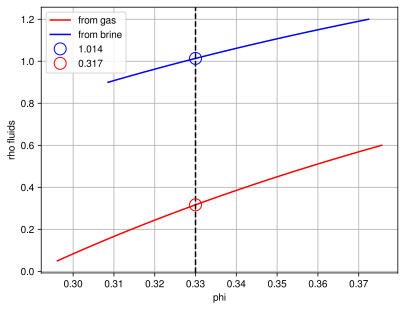

In [7]:
i = 'CLASS3'
phi = sandb.loc[i, 'PHI']
rhoB = sandb.loc[i, 'RHO']
rhoG = sandg.loc[i, 'RHO']

rho_b = np.linspace(0.9, 1.2)
rho_g = np.linspace(0.05, 0.6)

phi_from_bri = (rhoB - rho_m)/(rho_b - rho_m)
phi_from_gas = (rhoG - rho_m)/(rho_g - rho_m)

rho_brine_exact = (rhoB-rho_m*(1-phi)) / phi
rho_gas_exact = (rhoG-rho_m*(1-phi)) / phi

mrkg = dict(marker='o', color='r', ms=12, mfc='none', ls='none')
mrkb = dict(marker='o', color='b', ms=12, mfc='none', ls='none')

plt.figure()
plt.plot(phi_from_gas, rho_g, '-r', label='from gas')
plt.plot(phi_from_bri, rho_b, '-b', label='from brine')
if i != 'CLASS4':
    plt.axvline(sandb.loc[i, 'PHI'], ls='--', color='k')
plt.plot(phi, rho_brine_exact, label='{:.3f}'.format(rho_brine_exact), **mrkb)
plt.plot(phi, rho_gas_exact, label='{:.3f}'.format(rho_gas_exact), **mrkg)
plt.legend()
plt.xlabel('phi')
plt.ylabel('rho fluids')
plt.grid()

I store these values into dictionaries:

In [8]:
rho_b = {}
rho_g = {}
for i, ss in sandb.iterrows():
    if i != 'CLASS4':
        rhoB = sandb.loc[i, 'RHO']
        rhoG = sandg.loc[i, 'RHO']
        rho_b[i] = (rhoB-rho_m*(1-sandb.loc[i, 'PHI']))/sandb.loc[i, 'PHI']
        rho_g[i] = (rhoG-rho_m*(1-sandb.loc[i, 'PHI']))/sandb.loc[i, 'PHI']
        print('{:s}: rho brine={:.3f}, rho gas={:.3f}'.format(i, rho_b[i], rho_g[i]))

CLASS1: rho brine=1.000, rho gas=0.450
CLASS2: rho brine=0.970, rho gas=0.370
CLASS3: rho brine=1.014, rho gas=0.317


And copy the values for class 3 to class 4 since they should occur at similar depths (but this is unclear from Castagna's papers, so we are hunting in the dark right now):

In [9]:
rho_b['CLASS4'] = rho_b['CLASS3']
rho_g['CLASS4'] = rho_g['CLASS3']

Obviously when using these class-specific fluid densities starting from either brine or gas values I will now get the same porosities. The following code is redundant but since this is not a paper I will put it here as well:

In [10]:
for i, ss in sandb.iterrows():
    phi_from_bri = (ss['RHO'] - rho_m)/(rho_b[i] - rho_m)
    phi_from_gas = (sandg.loc[i, 'RHO'] - rho_m)/(rho_g[i] - rho_m)
    print('{:s}: given phi={:.2f}, phi from brine={:.2f},  phi from gas={:.2f}'.format(i, ss.PHI, phi_from_bri, phi_from_gas))

CLASS1: given phi=0.20, phi from brine=0.20,  phi from gas=0.20
CLASS2: given phi=0.25, phi from brine=0.25,  phi from gas=0.25
CLASS3: given phi=0.33, phi from brine=0.33,  phi from gas=0.33
CLASS4: given phi=0.00, phi from brine=0.27,  phi from gas=0.25


I now try a different approach using Gassmann's formula to derive porosity:

$$ \frac{k_{satB}} {k_m - k_{satG}} = \frac {k_d} {k_m - k_d} + \frac{k_B}{\phi \cdot (k_m - k_B)} $$

and

$$ \frac{k_{satG}} {k_m - k_{satG}} = \frac {k_d} {k_m - k_d} + \frac{k_G}{\phi \cdot (k_m - k_G)} $$

These two combined become:

$$ \phi = \frac{(k_m - k_{satB}) \cdot (k_m - k_{satG}) \cdot (k_B - k_G)}{(k_m - k_B) \cdot (k_m - k_G) \cdot (k_{satB} - k_{satG})}$$

An example of how to code the above:

In [14]:
k_b = 2.2
k_g = 0.02
k_m = 37

i = 'CLASS3'
q, w, e, phi_given = sandg.loc[i].values
ksat_g = bulk(q, w, e)

q, w, e, _ = sandb.loc[i].values
ksat_b = bulk(q, w, e)

phi = gassmann_phi(ksat_b, ksat_g, 2.1, k_g, k_m)
print('Porosity: calculated={:.4f}, given={:.4f}'.format(phi, phi_given))

Porosity: calculated=0.3224, given=0.3300


I also need to take into account that the fluids' bulk moduli are depth-dependant (and densities too): I should derive them systematically using Batzle-Wang equations but for now with simple trial and error I have derived the following brine bulk moduli:

Applying the same formula above to class 4:

In [15]:
i = 'CLASS4'
q, w, e, phi_given = sandg.loc[i].values
ksat_g = bulk(q, w, e)

q, w, e, _ = sandb.loc[i].values
ksat_b = bulk(q, w, e)

phi = gassmann_phi(ksat_b, ksat_g, k_b, k_g, k_m)
print('Porosity: calculated={:.4f}, given={:.4f}'.format(phi, phi_given))

Porosity: calculated=0.1633, given=0.0000


Yes, this is a very low porosity and very different to the one derived from the density formula. Anyway, I plug this porosity in for class 4 and then do frm starting from brine sand values using the given porosities, let's see what happens:

In [16]:
sandb.loc['CLASS4', 'PHI'] = phi
sandg.loc['CLASS4', 'PHI'] = phi

In [17]:
for i, ss in sandb.iterrows():
    print(ss.name)
    vp1, vs1, rho1, phi = ss.values
    vp2, vs2, rho2, *_ = gassmann(vp1, vs1, rho1, rho_b[i], k_b, rho_g[i], k_g, k_m, phi)
    vp_check, vs_check, rho_check = sandg.loc[i, ['VP', 'VS', 'RHO']].values
    print('Input=Brine Sand : Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp1, vs1, rho1))
    print('Output FRM to gas: Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp2, vs2, rho2))
    print('Given values:      Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp_check, vs_check, rho_check))
    itms = (percdiff(vp_check, vp2), percdiff(vs_check, vs2), percdiff(rho_check, rho2))
    print('Difference:        Vp={:+4.0%}, Vs={:+4.0%}, rho={:+4.0%}'.format(*itms))

CLASS1
Input=Brine Sand : Vp=4115, Vs=2453, rho=2.32
Output FRM to gas: Vp=4073, Vs=2513, rho=2.21
Given values:      Vp=4050, Vs=2526, rho=2.21
Difference:        Vp= +1%, Vs= -1%, rho= +0%
CLASS2
Input=Brine Sand : Vp=3048, Vs=1595, rho=2.23
Output FRM to gas: Vp=2784, Vs=1652, rho=2.08
Given values:      Vp=2781, Vs=1665, rho=2.08
Difference:        Vp= +0%, Vs= -1%, rho= +0%
CLASS3
Input=Brine Sand : Vp=2134, Vs=860, rho=2.11
Output FRM to gas: Vp=1522, Vs=911, rho=1.88
Given values:      Vp=1542, Vs=901, rho=1.88
Difference:        Vp= -1%, Vs= +1%, rho= +0%
CLASS4
Input=Brine Sand : Vp=2590, Vs=1060, rho=2.21
Output FRM to gas: Vp=1644, Vs=1088, rho=2.10
Given values:      Vp=1650, Vs=1090, rho=2.07
Difference:        Vp= -0%, Vs= -0%, rho= +1%


It all looks fine but:

1. how can such a low porosity sand have an increase of 940 m/s going from gas to brine?
2. if we set the porosity of class 4 to the higher value of 0.26 found by inverting the density formula, we obtain less fluid sensitivity than using 0.16; this means that Gassmann does not work properly and that can only happen if one of the inputs (velocities or density) is wrong.

Below is a little snippet of code showing fluid replacement on class 4 starting from both brine and gas sand  with the two different porosities; as it is counterintuitive to see *greater* fluid effect with lower porosities, then one of the inputs must be wrong!

In [18]:
i = 'CLASS4'
vpB, vsB, rhoB, _ = sandb.loc[i].values
vpG, vsG, rhoG, _ = sandg.loc[i].values

print('\nBRINE --> GAS')
print('initial:             vp={:5.0f}, vs={:5.0f}, rho={:5.2f}'.format(vpB, vsB, rhoB))
print('expected:            vp={:5.0f}, vs={:5.0f}, rho={:5.2f}'.format(vpG, vsG, rhoG))

phi = 0.26
vp2, vs2, rho2, ksat2, kdry2 = gassmann(vpB, vsB, rhoB, rho_b[i], k_b, rho_g[i], k_g, k_m, phi)
print('gassmann (phi={:.2f}): vp={:5.0f}, vs={:5.0f}, rho={:5.2f}, ksat={:5.2f}, kdry={:4.2f}'.format(phi, vp2, vs2, rho2, ksat2, kdry2))
phi = 0.15
vp2, vs2, rho2, ksat2, kdry2 = gassmann(vpB, vsB, rhoB, rho_b[i], k_b, rho_g[i], k_g, k_m, phi)
print('gassmann (phi={:.2f}): vp={:5.0f}, vs={:5.0f}, rho={:5.2f}, ksat={:5.2f}, kdry={:4.2f}'.format(phi, vp2, vs2, rho2, ksat2, kdry2))

print('\nGAS --> BRINE')
print('initial:             vp={:5.0f}, vs={:5.0f}, rho={:5.2f}'.format(vpG, vsG, rhoG))
print('expected:            vp={:5.0f}, vs={:5.0f}, rho={:5.2f}'.format(vpB, vsB, rhoB))

phi = 0.26
vp2, vs2, rho2, ksat2, kdry = gassmann(vpG, vsG, rhoG, rho_g[i], k_g, rho_b[i], k_b, k_m, phi)
print('gassmann (phi={:.2f}): vp={:5.0f}, vs={:5.0f}, rho={:5.2f}, ksat={:5.2f}, kdry={:4.2f}'.format(phi, vp2, vs2, rho2, ksat2, kdry2))
phi = 0.15
vp2, vs2, rho2, ksat2, kdry = gassmann(vpG, vsG, rhoG, rho_g[i], k_g, rho_b[i], k_b, k_m, phi)
print('gassmann (phi={:.2f}): vp={:5.0f}, vs={:5.0f}, rho={:5.2f}, ksat={:5.2f}, kdry={:4.2f}'.format(phi, vp2, vs2, rho2, ksat2, kdry2))


BRINE --> GAS
initial:             vp= 2590, vs= 1060, rho= 2.21
expected:            vp= 1650, vs= 1090, rho= 2.07
gassmann (phi=0.26): vp= 2192, vs= 1106, rho= 2.03, ksat= 6.44, kdry=6.39
gassmann (phi=0.15): vp= 1466, vs= 1086, rho= 2.11, ksat= 1.21, kdry=1.09

GAS --> BRINE
initial:             vp= 1650, vs= 1090, rho= 2.07
expected:            vp= 2590, vs= 1060, rho= 2.21
gassmann (phi=0.26): vp= 2310, vs= 1045, rho= 2.25, ksat= 8.74, kdry=1.09
gassmann (phi=0.15): vp= 2659, vs= 1063, rho= 2.17, ksat=12.10, kdry=1.09


Another test is to compute dry-rock bulk modulus for a range of porosities starting from brine and sand properties. Where they intersect, that's where we expect to find the 'correct' porosity. This works for classes 1-3 as expected, while for class 4 it obviously returns the same porosity I get by inverting Gassmann (0.163) and that I've shown above to be wrong.

Dry-rock bulk moduli are obviously much more prone to error if we use a denser fluid such as brine, that's why the blue lines below also reach negative (clearly incorrect) values.

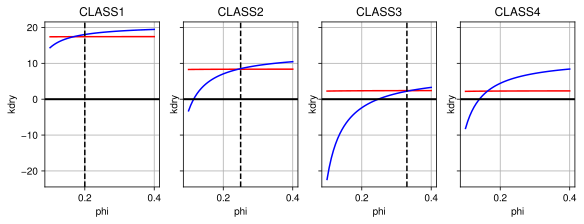

In [19]:
phi = np.linspace(.1, .4)

f, ax = plt.subplots(ncols=4, figsize=(8,3), sharey=True,constrained_layout=True)
for n in range(4):
    i = sandb.index[n]
    vpG, vsG, rhoG, _ = sandg.loc[i].values
    vp_0, vs_0, rho_0, ksat_0, kdry_0 = gassmann(vpG, vsG, rhoG, rho_g[i], k_g, rho_b[i], k_b, k_m, phi)
    vpB, vsB, rhoB, _ = sandb.loc[i].values
    vp_1, vs_1, rho_1, ksat_1, kdry_1 = gassmann(vpB, vsB, rhoB, rho_b[i], k_b, rho_g[i], k_g, k_m, phi)

    ax[n].plot(phi, kdry_0, '-r', label='from gas')
    ax[n].plot(phi, kdry_1, '-b', label='from brine')
    ax[n].axhline(0, ls='-', color='k', lw=2)
    if i != 'CLASS4':
        ax[n].axvline(sandb.loc[i, 'PHI'], ls='--', color='k')
    ax[n].set_xlabel('phi')
    ax[n].set_ylabel('kdry')
    ax[n].grid()
    ax[n].set_title(i)

What is the conclusion from all of this:

* let's not use the values for class 4 given by Castagna in both his 1997 and 1998 papers (brine: Vp=2590 m/s, Vs=1060 m/s, rho=2.21 g/cc; gas: Vp=1650 m/s, Vs=1090 m/s, rho=2.07 g/cc) they are wrong.
* class 4 is a further subdivision of class 3 so we have to assume similar petrophysical characteristics (and therefore, similar sedimentological setting perhaps?); what is peculiar of this class is what's *above*.
* to prove the point above, if we simply model the AVO response of the same class 3 sand overlain by the class 4 shale, we also get something that plots in the class 4 quadrant!

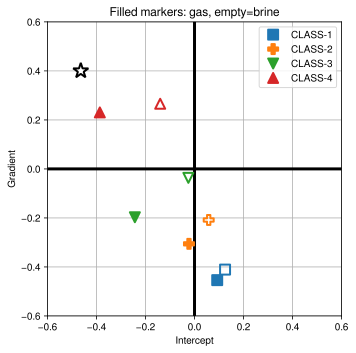

In [20]:
vp0, vs0, rho0 = shale.loc['CLASS4', ['VP', 'VS', 'RHO']].values
vp1, vs1, rho1 = sandg.loc['CLASS3', ['VP', 'VS', 'RHO']].values
classref(near=5, far=30, above=[vp0, vs0, rho0], below=[vp1, vs1, rho1])

Let's see the class 3 brine sand overlain with the class 4 shale:

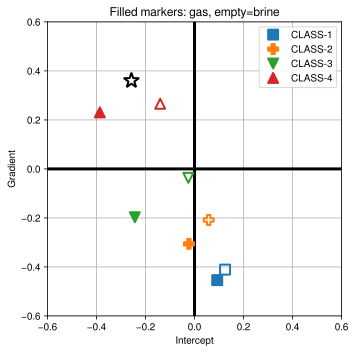

In [21]:
vp0, vs0, rho0 = shale.loc['CLASS4', ['VP', 'VS', 'RHO']].values
vp1, vs1, rho1 = sandb.loc['CLASS3', ['VP', 'VS', 'RHO']].values
classref(near=5, far=30, above=[vp0, vs0, rho0], below=[vp1, vs1, rho1], plot_brine=True)

## interactive bits

In [23]:
def phi_from_dens(avoclass, rho_m=2.65):
    phi = sandb.loc[avoclass, 'PHI']
    rhoB = sandb.loc[avoclass, 'RHO']
    rhoG = sandg.loc[avoclass, 'RHO']

    rho_b = np.linspace(0.9, 1.2)
    rho_g = np.linspace(0.05, 0.6)

    phi_from_bri = (rhoB - rho_m)/(rho_b - rho_m)
    phi_from_gas = (rhoG - rho_m)/(rho_g - rho_m)

    rho_brine_exact = (rhoB-rho_m*(1-phi)) / phi
    rho_gas_exact = (rhoG-rho_m*(1-phi)) / phi

    mrkg = dict(marker='o', color='r', ms=12, mfc='none', ls='none')
    mrkb = dict(marker='o', color='b', ms=12, mfc='none', ls='none')

    f, ax = plt.subplots(constrained_layout=True)
    ax.plot(phi_from_gas, rho_g, '-r', label='from gas')
    ax.plot(phi_from_bri, rho_b, '-b', label='from brine')
    ax.axvline(sandb.loc[avoclass, 'PHI'], ls='--', color='k')
    ax.plot(phi, rho_brine_exact, label='{:.3f} g/cc'.format(rho_brine_exact), **mrkb)
    ax.plot(phi, rho_gas_exact, label='{:.3f} g/cc'.format(rho_gas_exact), **mrkg)
    ax.legend(loc='lower right')
    ax.set_xlabel('Porosity')
    ax.set_ylabel('Fluid density (g/cc)')
    ax.grid()

In [24]:
w_avoc = ipw.ToggleButtons(description='AVO Class', options=['CLASS1', 'CLASS2', 'CLASS3'])
w_rhom = ipw.FloatSlider(value=2.65, description='Matrix density', max=2.8, min=2.5, step=0.02)
ui = ipw.VBox([w_avoc, w_rhom])
tool = ipw.interactive_output(phi_from_dens, {'avoclass': w_avoc, 'rho_m': w_rhom})

In [25]:
display(ui, tool)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1280x960 with 1 Axes>', '…

In [30]:
k_m = 37

k_w = 2.2
rho_w = 1.0

k_g = 0.02
rho_g = 0.32

def frm_check_pors(avoclass, phi):
    vpG, vsG, rhoG, phi_given = sandg.loc[avoclass]
    vpB, vsB, rhoB, _ = sandb.loc[avoclass]


    vp_0, vs_0, rho_0, ksat_0, kdry_0 = gassmann(vpG, vsG, rhoG, rho_g, k_g, rho_w, k_w, k_m, phi)
    vp_1, vs_1, rho_1, ksat_1, kdry_1 = gassmann(vpB, vsB, rhoB, rho_w, k_w, rho_g, k_g, k_m, phi)

    print('Given porosity:    {:.2f}'.format(phi_given))
    print('Assigned porosity: {:.2f}'.format(phi))

    print('\nBRINE --> GAS')
    print('Input (brine):     Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpB, vsB, rhoB))
    print('Reference (gas):   Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpG, vsG, rhoG))
    print('Output FRM gas:    Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp_1, vs_1, rho_1))   
    print('gassmann qc: ksat={:5.2f}, kdry={:4.2f}'.format(ksat_1, kdry_1))

    itms = (percdiff(vpB, vp_1), percdiff(vsB, vs_1), percdiff(rhoB, rho_1))
    print('Difference:        Vp={:+4.0%}, Vs={:+4.0%}, rho={:+4.0%}'.format(*itms))
    
    
    print('\nGAS --> BRINE')
    print('Input (gas):         Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpG, vsG, rhoG))
    print('Reference (brine):   Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpB, vsB, rhoB))
    print('Output FRM brine:    Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp_0, vs_0, rho_0))
    print('gassmann qc: ksat={:5.2f}, kdry={:4.2f}'.format(ksat_0, kdry_0))
    
    itms = (percdiff(vpG, vp_0), percdiff(vsG, vs_0), percdiff(rhoG, rho_0))
    print('Difference:        Vp={:+4.0%}, Vs={:+4.0%}, rho={:+4.0%}'.format(*itms))


In [31]:
ipw.interact(frm_check_pors,
             avoclass=ipw.ToggleButtons(options=['CLASS1', 'CLASS2', 'CLASS3', 'CLASS4'], value='CLASS4'),
             phi=ipw.FloatSlider(min=0.1, max=0.40, step=0.01, value=0.26))

interactive(children=(ToggleButtons(description='avoclass', index=3, options=('CLASS1', 'CLASS2', 'CLASS3', 'C…

<function __main__.frm_check_pors(avoclass, phi)>

## find a justification for Class 4 numbers with Rock Physics Modeling


_Work in progress. The idea is to set up a Monte Carlo simulation to capture the possibile variations of a real sand using rock physics modeling but I only arrived to setting up an initial porosity distribution._

Make 500 porosity samples following a normal distribution with:

$$ \mu = 0.2 $$
$$ \sigma = 0.03 $$

In [34]:
from scipy.stats import norm

ns = 500
phi_dist = norm.rvs(loc=0.2, scale=0.03, size=ns)

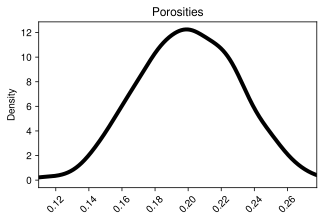

In [35]:
pd.Series(phi_dist).plot(kind='density', figsize=(5,3), xlabel='Porosity',
                         xlim=(phi_dist.min(), phi_dist.max()),
                         title='Porosities',
                         rot=45, color='k', lw=4);